In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import torch

PATH = "data/galaxy-zoo-2/"

In [60]:
# download SDSS images by getting ra/dec
df = pd.read_csv(f'{PATH}zoo2MainSpecz.csv')
pos = df[['ra', 'dec']].copy()
pos.insert(2, 'radius', 0.5 * np.ones_like(df.ra))


In [62]:
pos.shape

(243500, 3)

In [ ]:
pos.to_csv

In [5]:
# get labeled data (excluding test)
label_csv = f'{PATH}bpt_training.csv'
n = len(list(open(label_csv))) - 1 
val_idxs = get_cv_idxs(n)

# see a few
df = pd.read_csv(label_csv)
df.head()

,GalaxyID,BPTClass
0,129195,composite
1,118644,low-star-forming
2,662778,star-forming
3,740961,AGN
4,271648,LINER


In [6]:
# load in data with transforms
arch = resnet34
sz = 32
bs = 12

In [7]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_top_down, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'bpt_training', f'{PATH}bpt_training.csv', 
                                        test_name='bpt_testing', val_idxs=val_idxs, 
                                        suffix='.jpg', tfms=tfms, bs=bs)
    return data if sz < 256 else data.resize(256, 'tmp')

In [8]:
data = get_data(sz, bs)

In [9]:
# initialize network
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 151/151 [00:34<00:00,  4.38it/s]


Note: Using `sz=32` and `bs=12` uses < 2 GB of memory. Perhaps I can increase the batch size to 16 or 32.

In [10]:
# take a peek
learn

Sequential(
  (0): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True)
  (1): Dropout(p=0.25)
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True)
  (5): Dropout(p=0.5)
  (6): Linear(in_features=512, out_features=5, bias=True)
  (7): LogSoftmax()
)

In [12]:
# find learning rate
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 72%|███████▏  | 298/415 [00:01<00:00, 149.95it/s, loss=7.65]


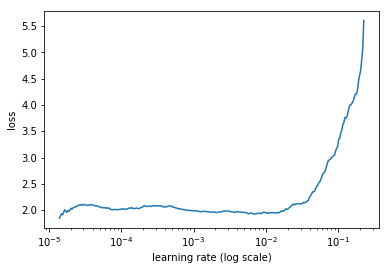

In [13]:
learn.sched.plot()

The loss seems to be flat between $10^{-5}$ to $10^{-2}$, which is not good. This may be due to the fact that the batch size is too small, and we don't have good representation of data across batches? I honestly don't know. Let's try increasing it.

In [16]:
sz = 32; bs = 64
data = get_data(sz, bs)

learn = ConvLearner.pretrained(arch, data, precompute=True)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 74%|███████▍  | 58/78 [00:00<00:00, 71.36it/s, loss=12]  


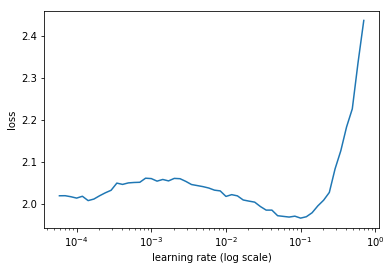

In [17]:
lrf=learn.lr_find()
learn.sched.plot()

Seems interesting. Here the learning rate looks more well-behaved. I don't know if my RAM can handle a batch size of 64, but let's give it a whirl!

In [18]:
lr = 1e-2
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.693527   1.451189   0.413043  
    1      1.575467   1.463983   0.413043                 
    2      1.547665   1.466139   0.406602                 



[array([1.46614]), 0.4066022547162865]

In [27]:
learn.fit(lr, 5, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=5), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.512049   1.460065   0.402576  
    1      1.505815   1.449285   0.417069                 
    2      1.502833   1.475951   0.409018                 
    3      1.483298   1.455259   0.419485                 
    4      1.481702   1.464214   0.41868                  



[array([1.46421]), 0.41867954930629514]

In [28]:
# differential learning rates
learn.unfreeze()

lr = np.array([1/9, 1/3, 1]) * 1e-2
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.53042    1.460206   0.409018  
    1      1.525024   1.444916   0.417069                 
    2      1.499838   1.425989   0.433977                 
    3      1.519453   1.459282   0.391304                 
    4      1.52281    1.427455   0.428341                 
    5      1.501315   1.423936   0.426731                 
    6      1.475768   1.419093   0.424316                 



[array([1.41909]), 0.42431562020774816]

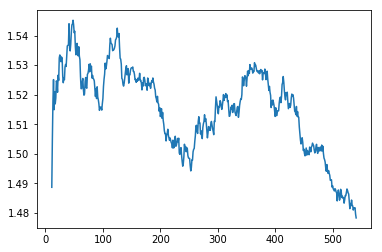

In [29]:
learn.sched.plot_loss()

In [30]:
# keep going on?
learn.fit(lr, 5, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=31), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                 
    0      1.495722   1.424158   0.425121  
    1      1.51574    1.449389   0.425121                 
    2      1.485145   1.435284   0.429952                 
    3      1.520379   1.470761   0.399356                 
    4      1.518508   1.438397   0.427536                 
    5      1.492497   1.434286   0.426731                 
    6      1.477822   1.422216   0.433172                 
    7      1.515245   1.464677   0.413849                 
    8      1.524254   1.438899   0.409823                 
    9      1.519735   1.452041   0.409823                 
    10     1.497013   1.425719   0.425121                 
  0%|          | 0/78 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Visualize

In [35]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

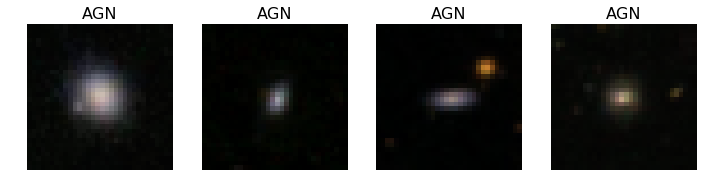

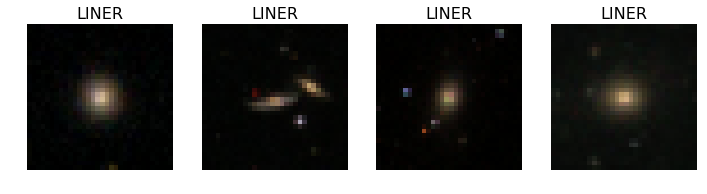

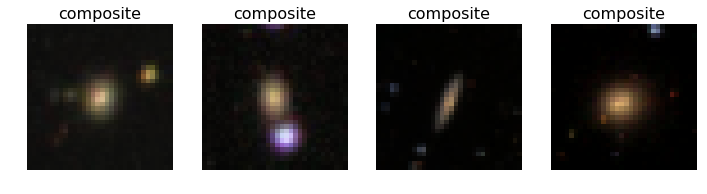

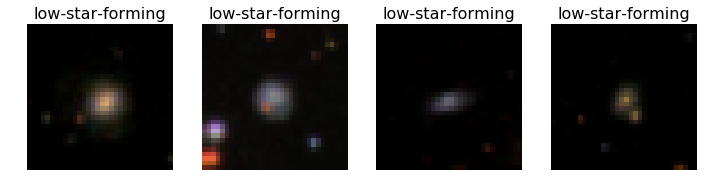

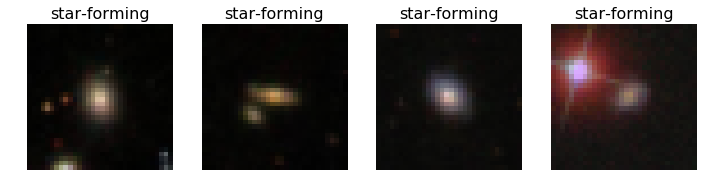

In [58]:
# let's look at a few training galaxies by BPT classification
df = pd.read_csv(label_csv)
for i, bptclass in enumerate(data.classes):
    mask = data.trn_y == i
    inds = rand_by_mask(mask)
    
    imgs = np.stack([data.trn_ds[x][0] for x in inds])

    plots(data.val_ds.denorm(imgs), titles=[bptclass]*4)

## Crap..
Could it be that my data "cleaning" was incorrect?